# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [23]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

### Ragusa environnement

import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml
# %env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/nndc_hdf5/cross_sections.xml

### Pablo environnement

In [24]:
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]
for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

### Define Materials

In [25]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')
model.materials = openmc.Materials([uo2, zirconium, water]) 
#Perso path
model.materials.cross_sections = '/home/pablo/internship/xs_for_input/cross_sections.xml'
#Mac path
# model.materials.cross_sections = '/Users/pablogarcia44/repo/cross_sections.xml'

### Create pincell

In [26]:
def pincell(family):
    fuel_outer_radius = openmc.ZCylinder(r=0.39)
    clad_inner_radius = openmc.ZCylinder(r=0.40)
    clad_outer_radius = openmc.ZCylinder(r=0.46)
    pitch = 1.26
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')
    fuel_region = -fuel_outer_radius
    gap_region = +fuel_outer_radius & -clad_inner_radius
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    fuel = openmc.Cell(name='fuel'+'_'+family)
    fuel.fill = uo2
    fuel.region = fuel_region
    gap = openmc.Cell(name='gap'+'_'+family)
    gap.region = gap_region
    clad = openmc.Cell(name='clad'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    u = openmc.Universe(name='u'+'_'+family,cells=(fuel, gap, clad, moderator))
    return(u,fuel,gap,clad,moderator)

### Create guide tube

In [27]:
def guide(family):
    clad_inner_radius = openmc.ZCylinder(r=0.5610)
    clad_outer_radius = openmc.ZCylinder(r=0.6020)
    pitch = 1.26
    left = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right = openmc.XPlane(pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top = openmc.YPlane(pitch/2, boundary_type='transmission')       
    clad_region = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    water_guide_region= -clad_inner_radius
    water_guide = openmc.Cell(name='water_guide'+'_'+family)
    water_guide.fill = water
    water_guide.region = water_guide_region
    clad = openmc.Cell(name='clad_guide'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    u = openmc.Universe(name='u_guide'+'_'+family,cells=(water_guide, clad, moderator))
    return(u,water_guide,water_guide,clad,moderator)

### Mappping

In [28]:
C=[(0,0)]
E=[(1,0),(0,1),(2,0),(0,2),(3,0),(0,3),(4,0),(0,4),(5,0),(0,5),(6,0),(0,6),(7,0),(0,7),(8,0),(0,8)]
N=[(1,1),(2,1),(1,2),(3,1),(1,3)]
D=[(1,4),(4,1),(1,5),(6,1),(1,6),(7,1),(1,7),(2,2),(7,3),(3,7),(4,4),(6,4),(4,6),(7,4),(4,7),(6,6),(7,6),(6,7),(7,7),(6,3),(3,6)]
F=[(5,1),(1,5),(8,1),(1,8),(3,2),(2,3),(2,6),(6,2),(2,7),(7,2),(5,3),(3,5),(8,3),(3,8),(5,4),(4,5),(8,4),(4,8),(6,5),(5,6),(7,5),(5,7),(8,6),(6,8),(8,7),(7,8)]
FD=[(4,2),(2,4),(4,3),(3,4)]
GT=[(5,2),(8,2),(3,3),(2,5),(5,5),(8,5),(2,8),(5,8),(8,8)]

E_left=[]
E_full=[]
for X in E:
    E_left.append((X[0],X[1]))
    E_left.append((X[0],16-X[1]))
for X in E_left:
    E_full.append((X[0],X[1]))
    E_full.append((16-X[0],X[1]))
E_full = list(set(E_full))

C_left=[]
C_full=[]
for X in C:
    C_left.append((X[0],X[1]))
    C_left.append((X[0],16-X[1]))
for X in C_left:
    C_full.append((X[0],X[1]))
    C_full.append((16-X[0],X[1]))
C_full = list(set(C_full))

    
N_left=[]
N_full=[]
for X in N:
    N_left.append((X[0],X[1]))
    N_left.append((X[0],16-X[1]))
for X in N_left:
    N_full.append((X[0],X[1]))
    N_full.append((16-X[0],X[1]))
N_full = list(set(N_full))


D_left=[]
D_full=[]
for X in D:
    D_left.append((X[0],X[1]))
    D_left.append((X[0],16-X[1]))
for X in D_left:
    D_full.append((X[0],X[1]))
    D_full.append((16-X[0],X[1]))   
D_full = list(set(D_full))


F_left=[]
F_full=[]
for X in F:
    F_left.append((X[0],X[1]))
    F_left.append((X[0],16-X[1]))
for X in F_left:
    F_full.append((X[0],X[1]))
    F_full.append((16-X[0],X[1]))    
F_full = list(set(F_full))

FD_left=[]
FD_full=[]
for X in FD:
    FD_left.append((X[0],X[1]))
    FD_left.append((X[0],16-X[1]))
for X in FD_left:
    FD_full.append((X[0],X[1]))
    FD_full.append((16-X[0],X[1]))    
FD_full = list(set(FD_full))


GT_left=[]
GT_full=[]
for X in GT:
    GT_left.append((X[0],X[1]))
    GT_left.append((X[0],16-X[1]))
for X in GT_left:
    GT_full.append((X[0],X[1]))
    GT_full.append((16-X[0],X[1]))    
GT_full = list(set(GT_full))

### Create family pincell

In [29]:
pincell_C=pincell('C')
pincell_E=pincell('E')
pincell_N=pincell('N')
pincell_D=pincell('D')
pincell_F=pincell('F')
pincell_FD=pincell('FD')
guide_GT=guide('GT')


### Define assembly

In [30]:
assembly = openmc.RectLattice()
pitch=1.26

dr=2e-1 # cm of water that is outside assembly
size=17 #size of the assembly 
pitch_assembly=size*pitch+2*dr 
assembly.pitch = (pitch,pitch)

assembly.lower_left = (-size/2*pitch, -size/2*pitch)




A= np.empty((size, size), dtype=openmc.universe.Universe)

for ix in range(size):
    for iy in range(size):
        if (ix,iy) in C_full:
            A[ix][iy]=pincell_C[0]
        if (ix,iy) in E_full:
            A[ix][iy]=pincell_E[0]
        if (ix,iy) in N_full:
            A[ix][iy]=pincell_N[0]
        if (ix,iy) in D_full:
            A[ix][iy]=pincell_D[0]            
        if (ix,iy) in F_full:
            A[ix][iy]=pincell_F[0]
        if (ix,iy) in FD_full:
            A[ix][iy]=pincell_FD[0]
        if (ix,iy) in GT_full:
            A[ix][iy]=guide_GT[0]

# print(A)           
            
            

        
assembly.universes = A

moderator_outside = openmc.Cell()
moderator_outside.fill = water
all_water = openmc.Universe()
all_water.add_cell(moderator_outside)
assembly.outer=all_water

# 1/4 assembly
min_x = openmc.XPlane(x0=-(size/2*pitch+dr), boundary_type='reflective')
max_x = openmc.XPlane(x0=0, boundary_type='reflective')
min_y = openmc.YPlane(y0=0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+(size/2*pitch+dr), boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')


root_cell = openmc.Cell(name='root cell', fill=assembly)
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

model.geometry.root_universe = openmc.Universe(name='root universe')
model.geometry.root_universe.add_cell(root_cell)


### Plot

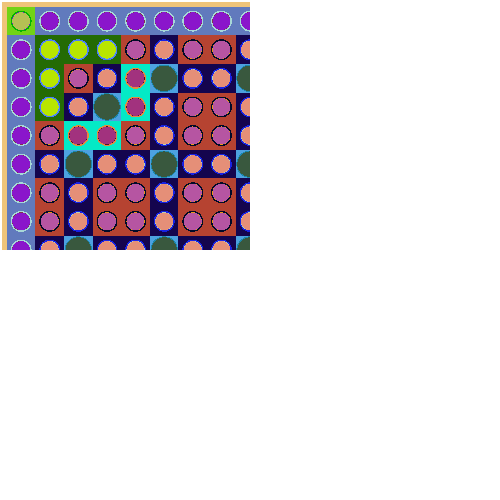

In [31]:
model.materials.export_to_xml()
model.geometry.export_to_xml()
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (pitch_assembly+dr, pitch_assembly+dr)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

### Choose settings

In [32]:
bounds = [-pitch_assembly/2, 0, -10, 0, +pitch_assembly/2, 10]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
source = openmc.IndependentSource(space=uniform_dist)
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 500000
settings.output = {'tallies':True}
model.settings = settings

### Define and choose energy group

In [33]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
name_group='XMAS172'

### Create MGXS tallies for mgxs directory

In [34]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi', 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
model.tallies = tallies

#model.export_to_xml()
model.export_to_model_xml()

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1596.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=800.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=808.
  warn(msg, IDWarning)


### Run OpenMC model

In [35]:
sp_file = model.run()

[Machine2:22483] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%